# DTSA-5511 Week 4 - NLP Disaster Tweets Kaggle Mini-Project

A Jupyter notebook with a description of the problem/data, exploratory data analysis (EDA) procedure, analysis (model building and training), result, and discussion/conclusion.

## Problem
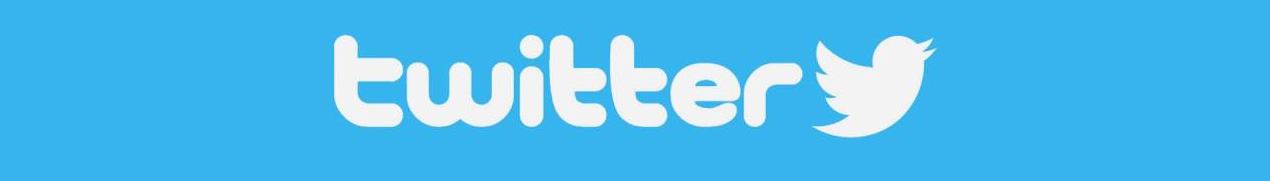
Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). The challenge of this Kaggle Mini-project is to use NLP (Natural Language Processing) to predict which Tweets are about real disasters and which one's arent.

## Dataset
The dataset was created by the company figure-eight and originally shared on their ['Data For Everyone'](https://appen.com/pre-labeled-datasets/)
Tweet source: [https://twitter.com/AnyOtherAnnaK/status/629195955506708480](https://twitter.com/AnyOtherAnnaK/status/629195955506708480)

Each sample in the train and test set has the following information:
- The text of a tweet.
- A keyword from that tweet (although this may be blank!).
- The location the tweet was sent from (may also be blank).

## 1. Exploratory Data Analysis (EDA)

### 1.1. Importing libraries
Loading libraries required this mini-project

In [44]:
# Utlity
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import plotly.express as px
import seaborn as sns

# EDA
import re
import missingno as msno
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# modeling and training
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

### 1.2. Reading data
#### 1.2.1. Train data
Loading train dataset from train.csv file.

In [3]:
train_df = pd.read_csv("./data/npl/train.csv")
display(train_df.head(), train_df.describe(include='all'))

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [4]:
print('Train dataset contains %d columns and %d rows' %(train_df.shape[0], train_df.shape[1]))

Train dataset contains 7613 columns and 5 rows


#### 1.2.2. Test data
Loading the test dataset from test.csv file.

In [5]:
test_df = pd.read_csv("./data/npl/test.csv")
display(test_df.head(), test_df.describe(include='all'))

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


,id,keyword,location,text
count,3263.000000,3237,2158,3263
unique,NaN,221,1602,3243
top,NaN,deluged,New York,11-Year-Old Boy Charged With Manslaughter of T...
freq,NaN,23,38,3
mean,5427.152927,NaN,NaN,NaN
std,3146.427221,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,2683.000000,NaN,NaN,NaN
50%,5500.000000,NaN,NaN,NaN
75%,8176.000000,NaN,NaN,NaN


In [6]:
print('Test dataset contains %d columns and %d rows' %(test_df.shape[0], test_df.shape[1]))

Test dataset contains 3263 columns and 4 rows


#### 1.2.3 Submission data
Loading the submission data from sample_submission.csv file.

In [7]:
submission_df = pd.read_csv("./data/npl/sample_submission.csv")
submission_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


### 1.3. Data Inspection
#### 1.3.1. Inspecting for null values
Checking if the train and test dataset contains null values

In [8]:
# train dataset
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

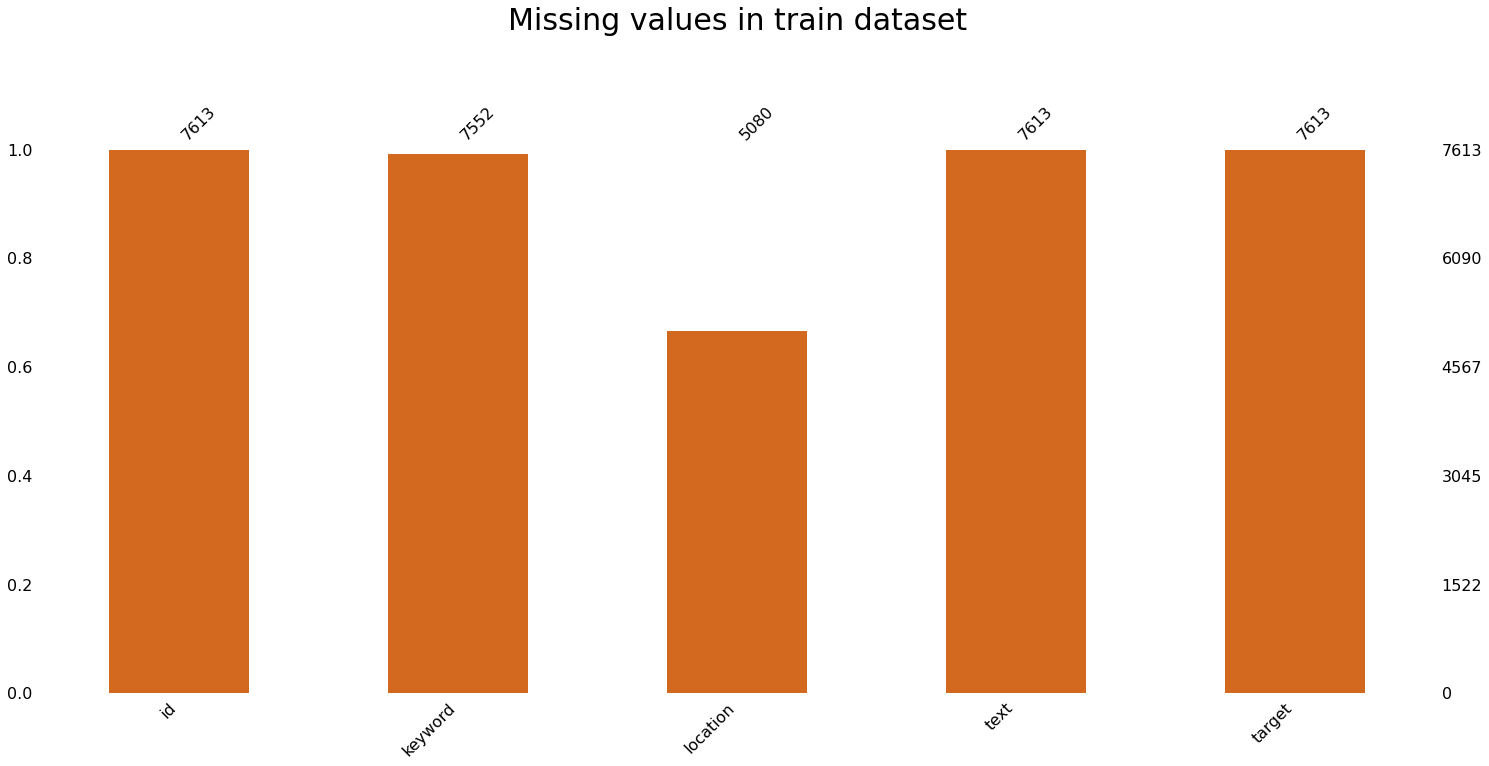

In [9]:
msno.bar(train_df,color = 'chocolate')
plt.title('Missing values in train dataset\n\n',fontsize=30)
plt.show()

In [10]:
# test dataset
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

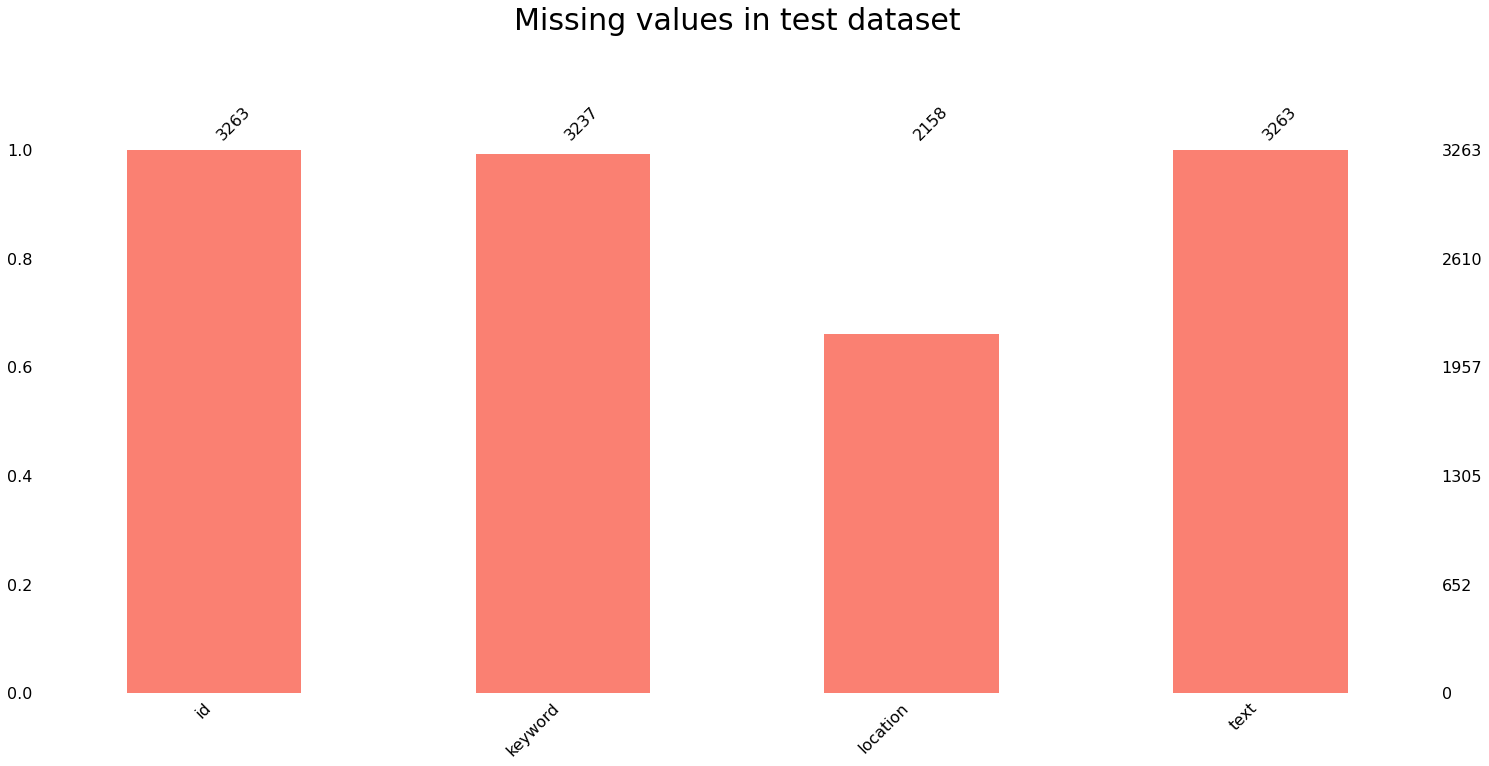

In [11]:
msno.bar(test_df,color = 'salmon')
plt.title('Missing values in test dataset\n\n',fontsize=30)
plt.show()

The plots show that keyword and location have missing value but location has more missing values than keyword on both datasets.

#### 1.3.2. Inspecting the target distribution

Checking the distribution of the target feature on the train dataset.

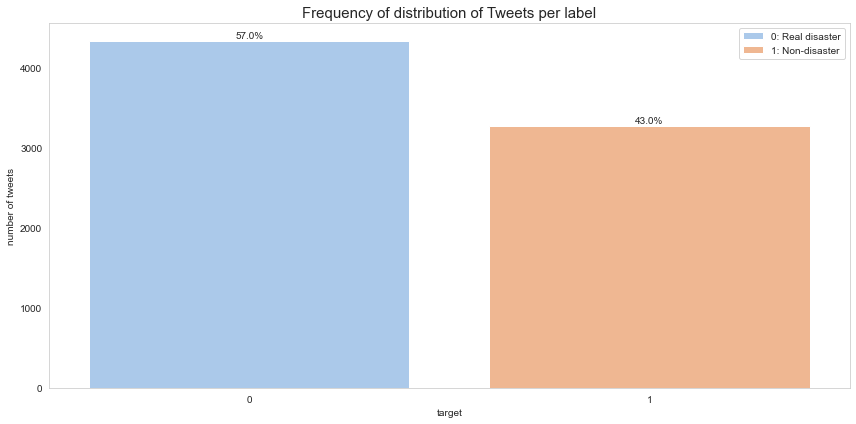

In [12]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,6))

ax = sns.countplot(x='target',data=train_df, palette="pastel",hue="target",dodge=False)
ax.grid(False) #remove grid
# Labels
plt.title('Frequency of distribution of Tweets per label',fontsize=15)
plt.ylabel("number of tweets")

# Percentage
total = len(train_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
# legend
plt.legend(loc='upper right',labels = ['0: Real disaster', '1: Non-disaster'])
plt.show()

The plot shows that there are more tweets with real disasters than non-real ones.

#### 1.3.3. Counting the keywords
Counting on train and test datasets the number of words on keyword feature.

In [13]:
# train dataset
kwd_cnt_train = train_df['keyword'].value_counts()
kwd_cnt_train

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [14]:
# test dataset
kwd_cnt_test = test_df['keyword'].value_counts()
kwd_cnt_test

deluged               23
demolished            22
rubble                22
first%20responders    21
seismic               21
                      ..
threat                 5
fatalities             5
forest%20fire          5
inundation             4
epicentre              1
Name: keyword, Length: 221, dtype: int64

#### 1.3.4. Top 20 keywords in tweets
Plotting the top 20 keywords in tweets on train and test datasets.

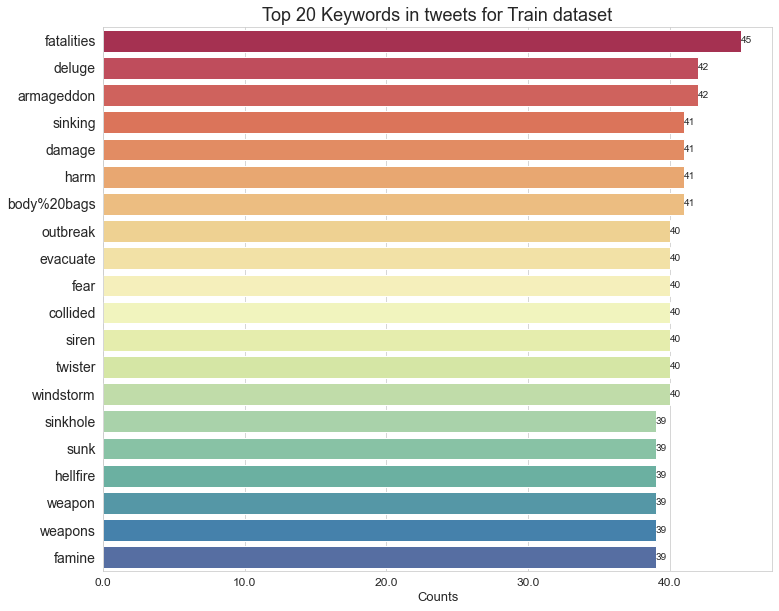

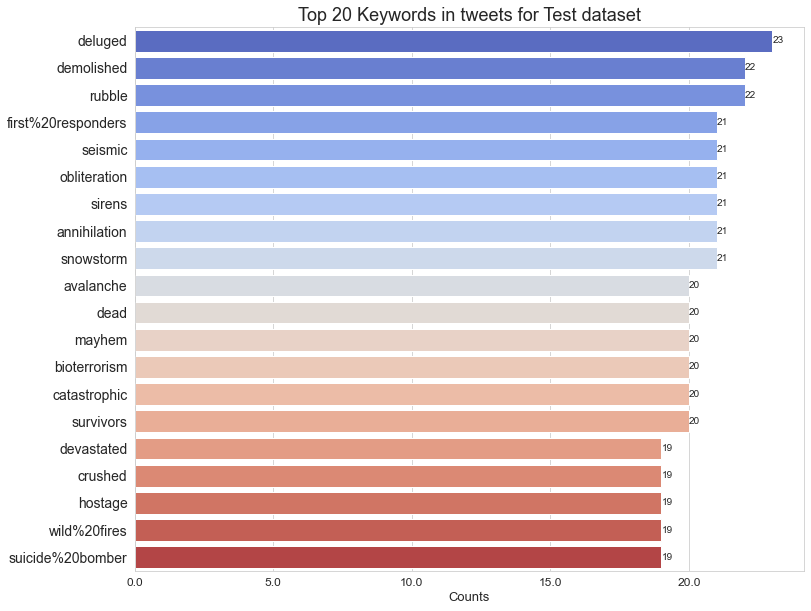

In [15]:
def top_tweet_keyword(df, dtype, color, ntop=20):
    sns.set_style('whitegrid')
    fig,axes = plt.subplots(figsize=(12,10))

    top_keywords=df['keyword'].value_counts()[:ntop]
    ax = sns.barplot(y=top_keywords.index,x=top_keywords,palette=color,data=df)
    for container in ax.containers:
        ax.bar_label(container)

    ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize = 12)    
    ax.set_yticklabels([t.get_text()  for t in ax.get_yticklabels()], fontsize = 14)
    plt.title('Top %d Keywords in tweets for %s dataset' %(ntop, dtype), fontsize=18)
    plt.xlabel('Counts', fontsize=13)
    plt.show()
    
top_tweet_keyword(train_df, 'Train', 'Spectral')
top_tweet_keyword(test_df, 'Test', 'coolwarm')

#### 1.3.5. Top 20  locations tweets sent from
Plotting the top 20 locations tweets sent from on train and test datasets.

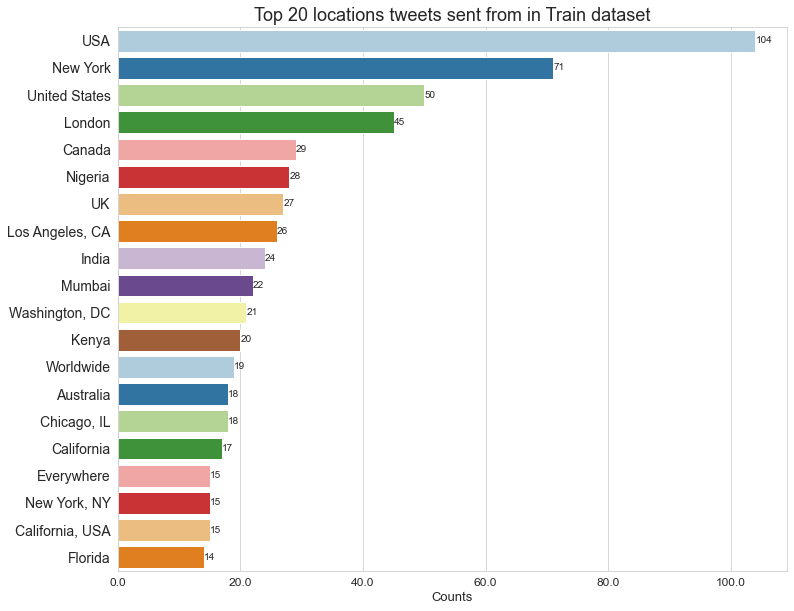

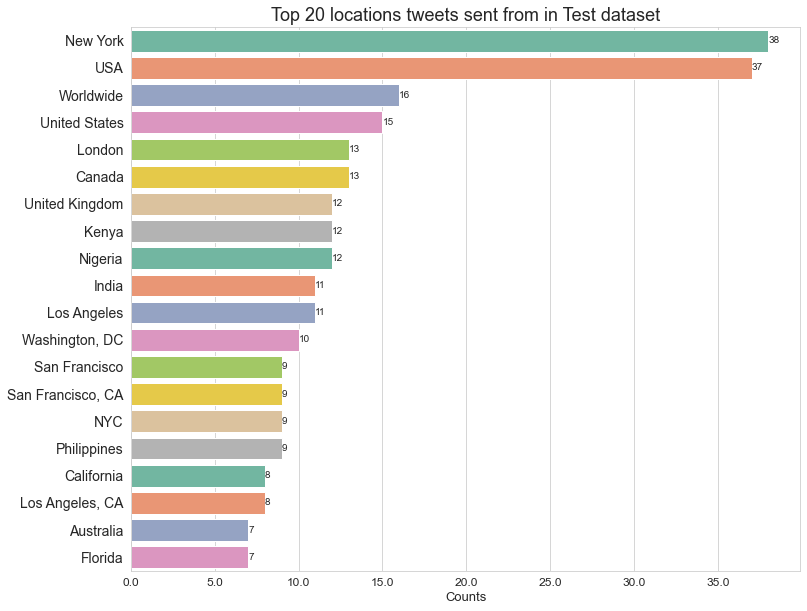

In [16]:
def top_tweet_location(df, dtype, color, ntop=20):
    sns.set_style('whitegrid')
    fig,axes = plt.subplots(figsize=(12,10))

    locations = df["location"].value_counts()
    ax = sns.barplot(y=locations[0:20].index,x=locations[0:20],palette=color,data=df)
    for container in ax.containers:
        ax.bar_label(container)
    ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize = 12)    
    ax.set_yticklabels([t.get_text()  for t in ax.get_yticklabels()], fontsize = 14)    
    plt.title('Top %d locations tweets sent from in %s dataset' %(ntop, dtype),fontsize=18)
    plt.xlabel('Counts', fontsize=13)
    plt.show()
    
top_tweet_location(train_df, 'Train', 'Paired')
top_tweet_location(test_df, 'Test', 'Set2')

The locations registered in the data can be countries, states, cities or worldwide. Most tweets are sent from the USA in train dataset. But most tweets are sent from New York in test dataset.

#### 1.3.6. Distribution of tweets
Plotting how the tweets are distrubuted before cleaning the data.

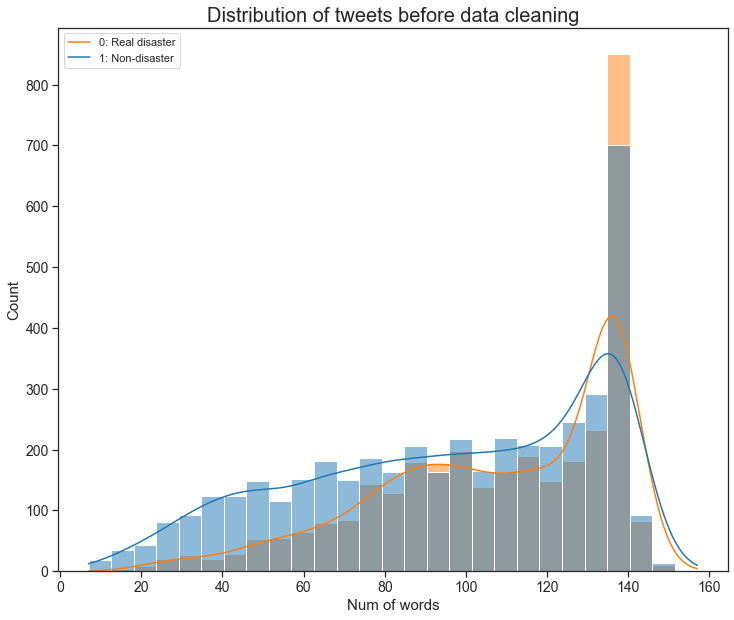

In [17]:
# Add tweets length column
train_df['numwords']  = train_df["text"].apply(len)
test_df['numwords']  = test_df["text"].apply(len)

# Plot histogram of tweets length
def dist_tweet(df, title, col, color):
    sns.set(rc={"figure.figsize":(12, 10)})
    sns.set_style("ticks")
    plot = sns.histplot(
        data = df, 
        x = col,
        kde = True,
        hue = 'target',
        palette = color
        )
    plot.set_xlabel('Num of words', fontsize = 15)
    plot.set_ylabel('Count', fontsize = 15)
    plot.set_title(title, fontsize = 20)
    plt.tick_params(labelsize = 14)
    plt.legend(loc='upper left',labels = ['0: Real disaster', '1: Non-disaster'])
    plt.show()
    
dist_tweet(train_df, "Distribution of tweets before data cleaning", 'numwords', 'tab10')

From the above distribution, it can be seen that the most length of tweets lies between the range of 130 - 140 characters.

#### 1.3.7. Top 3 tweets according to the length of tweets train dataset
Displaying the top 3 tweets on the train dataset.

In [18]:
for tweet in train_df.sort_values(by="numwords", ascending=False)["text"][:3]:
    print(f"Tweet: \n{tweet}\n")

Tweet: 
when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????

Tweet: 
It's was about 2:30 in the morning&amp;I went downstairs to watch some telly&amp;I accidentally made a loud bang&amp;my dad(who has a broken leg)walked-

Tweet: 
@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP



### 1.4. Data Pre-processing
From the previous step, we can conclude from the data that there is no standard format on the tweets, there are many symbols on the tweets, there are several special characters on the tweets, and some tweets have URLs.

To deal with these problems, I am performing the following data cleaning:
- Removing punctuations.
- Removing numbers.
- Converting to lowercase.
- Removing stopwords.
- Removing html tags
- Removing URLS
- Removing special characters
- Lemmatization
- Removing single characters

In [19]:
def data_cleaning(tweet):
    # remove punctuations
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # remove numbers
    tweet = re.sub(r'[0-9]', '', tweet)
    
    # converting to lowercase
    tweet = tweet.lower()

    # Stop word removal
    lemma = WordNetLemmatizer()
    tweet = " ".join(word for word in word_tokenize(tweet) if word not in stopwords.words('english'))
    
    # removing html tags
    tweet = re.sub(r"&.*?;|<.*?>", " ", tweet)
    
    # url removal
    tweet = re.sub(r"https?://\S+|www\.\S+", " ", tweet)

    # non word removals (special chars)
    tweet = re.sub(r"[^a-z]", " ", tweet)
    
    # lemmatization
    tweet = " ".join(lemma.lemmatize(word) for word in word_tokenize(tweet))
    
    # Single char removal
    tweet = re.sub(r"\b\w\b", "", tweet).strip()

    return tweet

In [20]:
# apply data cleaning to the train and test datasets
train_df["cleaned_text"] = train_df["text"].apply(data_cleaning)
test_df["cleaned_text"] = test_df["text"].apply(data_cleaning)

In [21]:
# find the number of words after cleaning the data
train_df["cleaned_words"] = train_df["cleaned_text"].apply(lambda x: len(re.sub(r"[\W_]", " ", x).split()))

In [22]:
train_df

,id,keyword,location,text,target,numwords,cleaned_text,cleaned_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,deed reason earthquake may allah forgive,6
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,resident asked shelter place notified officer ...,11
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfire evacuation order calif...,6
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfire pour...,9
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,two giant crane holding bridge collapse nearby...,9
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,aria ahrary thetawniest control wild fire cali...,12
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,utckm volcano hawaii httptcozdtoydebj,4
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,police investigating ebike collided car little...,14


#### 1.4.1. Handling null values
Removing irrelevant feature and filling missing values

In [23]:
# Removing irrelevant feature
train_df.drop(["location","id"],axis=1)

# filling keword missing value
train_df['keyword'].replace({"Na":'notkey'},inplace=True)

#### 1.4.2. Distribution of tweets after data cleaning
Plotting how the tweets are distrubuted after cleaning the data.

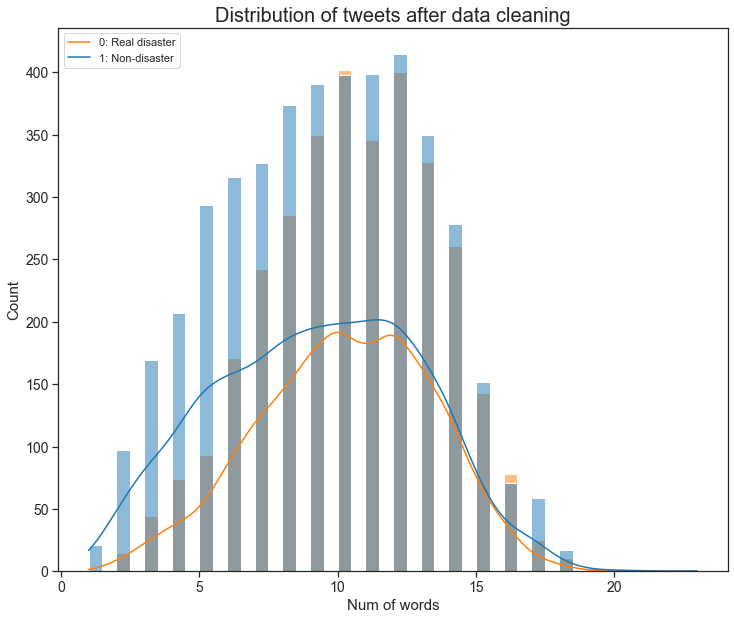

In [24]:
dist_tweet(train_df, "Distribution of tweets after data cleaning", 'cleaned_words', 'tab10')

#### 1.4.3. Wordcloud generation
Highlighting essential textual data points on the cleaned text feature.

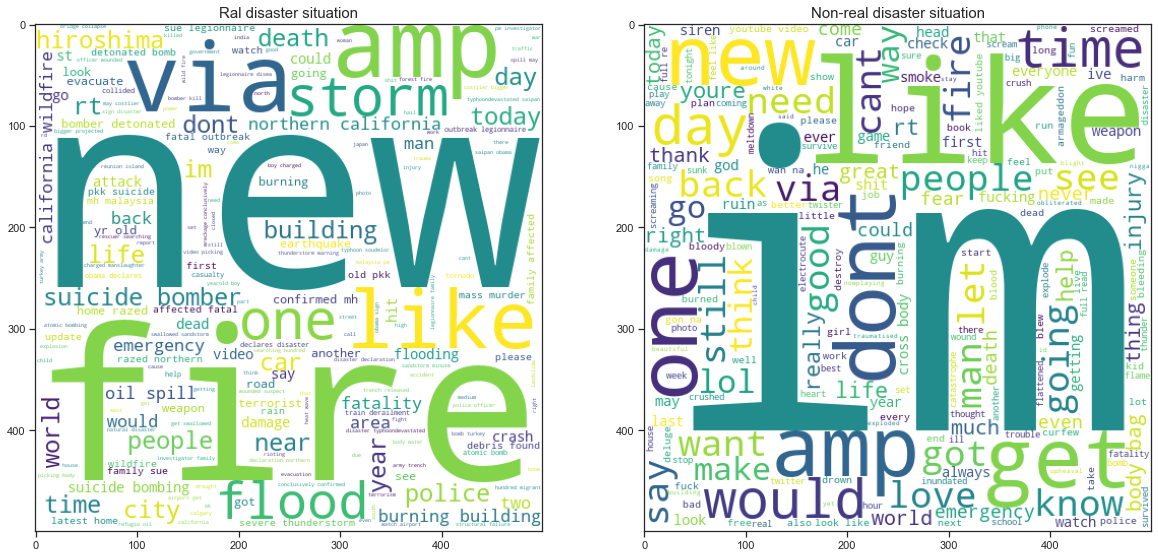

In [25]:
text1=[]
for i in train_df.loc[train_df['target']==1,'cleaned_text'].dropna():
      for j in i.lower().strip().split():
            text1.append(j)

text0=[]
for i in train_df.loc[train_df['target']==0,'cleaned_text'].dropna():
      for j in i.lower().strip().split():
            text0.append(j)
            
# Word cloud of clean word has real disaster situation
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
cloud1=WordCloud(background_color="white",max_font_size=400,width=500,height=500,stopwords="eng",random_state=10,repeat=True)
cloud1.generate(' '.join(text1))
plt.title("Ral disaster situation",size=15)
plt.imshow(cloud1)


# Word cloud of keyword has non-disaster Sitution
plt.subplot(1,2,2)
cloud1=WordCloud(background_color="white",max_font_size=400,width=500,height=500,stopwords="eng",random_state=10,repeat=True)
cloud1.generate(' '.join(text0))
plt.title("Non-real disaster situation",size=15)
plt.imshow(cloud1)            

## 2. Training, modeling and prediction
Feeding with clean train data into the LSTM model for modeling and prediction.

### 2.1. Token and vocabulary creation
Processing the raw text for the NLP.

In [27]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_df['cleaned_text'].values)
X = tokenizer.texts_to_sequences(train_df['cleaned_text'].values)
X = pad_sequences(X)
y = train_df['target']

### 2.2. Train and test split
Splitting the data set into two pieces: a training set and a testing set. The test_size is given as 0.2 , it means 20% of our data goes into our test size. 1-test_size is our train size.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =41)

### 2.3. Model creation
Creating the LSTM model.

In [29]:
model = Sequential()
model.add(Embedding(max_features, 32,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 19, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


### 2.4. Fitting the model
Measuring how well the LSTM model performs with the train dataset.

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test), callbacks= [callbacks])

Epoch 1/10
191/191 [==============================] - 4s 11ms/step - loss: 0.5483 - accuracy: 0.7174 - val_loss: 0.4221 - val_accuracy: 0.8181 - lr: 0.0020
Epoch 2/10
191/191 [==============================] - 2s 10ms/step - loss: 0.3724 - accuracy: 0.8407 - val_loss: 0.4315 - val_accuracy: 0.8122 - lr: 0.0020
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.3161 - accuracy: 0.8704 - val_loss: 0.4603 - val_accuracy: 0.8070 - lr: 0.0020
Epoch 4/10
191/191 [==============================] - 2s 9ms/step - loss: 0.2764 - accuracy: 0.8826 - val_loss: 0.5372 - val_accuracy: 0.7984 - lr: 0.0020
Epoch 5/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2407 - accuracy: 0.8987 - val_loss: 0.6437 - val_accuracy: 0.7853 - lr: 0.0020
Epoch 6/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2117 - accuracy: 0.9126 - val_loss: 0.7676 - val_accuracy: 0.7794 - lr: 0.0020


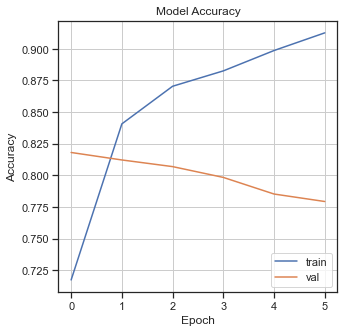

In [38]:
plt.figure(figsize=(5, 5))
plt.grid()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### 2.5. Prediction
Predicting the model on the test dataset to get the results.

In [39]:
# Tokenization on full train dataset
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_df['cleaned_text'].values)
X = tokenizer.texts_to_sequences(train_df['cleaned_text'].values)
X = pad_sequences(X, maxlen = 50)

In [40]:
# Tokenixation on full test dataset
tokenizer.fit_on_texts(test_df['cleaned_text'].values)
test_token = tokenizer.texts_to_sequences(test_df['cleaned_text'].values)
test_token = pad_sequences(test_token, maxlen = 50)

In [41]:
# Model call with little bit of optimisation based on previous results
lstm_out = 100
model = Sequential()
model.add(Embedding(max_features, 100, input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           500000    
                                                                 
 dropout_1 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [48]:
modelsub = model.fit(X,y, epochs = 10,validation_split = 0.2 ,callbacks=[callbacks], batch_size=32)

Epoch 1/10
191/191 [==============================] - 13s 68ms/step - loss: 0.1041 - accuracy: 0.9560 - val_loss: 1.1184 - val_accuracy: 0.7295 - lr: 2.0000e-04
Epoch 2/10
191/191 [==============================] - 13s 68ms/step - loss: 0.0885 - accuracy: 0.9612 - val_loss: 1.2813 - val_accuracy: 0.7249 - lr: 2.0000e-04
Epoch 3/10
191/191 [==============================] - 13s 68ms/step - loss: 0.0804 - accuracy: 0.9634 - val_loss: 1.3644 - val_accuracy: 0.7308 - lr: 2.0000e-04
Epoch 4/10
191/191 [==============================] - 13s 69ms/step - loss: 0.0748 - accuracy: 0.9663 - val_loss: 1.4930 - val_accuracy: 0.7282 - lr: 2.0000e-04
Epoch 5/10
191/191 [==============================] - 13s 67ms/step - loss: 0.0744 - accuracy: 0.9675 - val_loss: 1.4991 - val_accuracy: 0.7275 - lr: 2.0000e-04
Epoch 6/10
191/191 [==============================] - 13s 67ms/step - loss: 0.0680 - accuracy: 0.9683 - val_loss: 1.6549 - val_accuracy: 0.7223 - lr: 2.0000e-04
Epoch 7/10
191/191 [==============

In [47]:
y_hat = model.predict(test_token).round()
submission_df['target'] = np.round(y_hat).astype('int')
submission_df.to_csv('submission.csv', index=False)
submission_df.describe()

102/102 [==============================] - 1s 10ms/step


,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.414343
std,3146.427221,0.492684
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


## 3. Discussion
### 3.1. Conclusion
From the data inspection, I found that location and keyword features contain null values on train and test datasets. By inspecting the target feature, the distribution shows that there are more tweets with real disasters than non-real ones. I also concluded from the data inspection the following: there is no standard format on the tweets, there are many symbols on the tweets, there are several special characters on the tweets, and some tweets have URLs. Thus, I created a function to deal with all these problems. 

Once the data was cleaned, I created the token and vocabulary for the NLP method. For model creation, I added embedding layer to enable the conversion of each word into a fixed length vector of defined sized followed by dropout layer for prevention against overfitting. For the LSTM layer, I added 50 units that represent the dimensionality of outer space. For adding droput lauers, I specified the percentage of layers that should be dropped. The next step was to add the dense layer, and to compile the model with the adam optmizer. The perfect accuracy for train and validation is reached by getting close to 1 epoch.

### 3.2. Further improvement
Tune better the parameters on the model to get 90% on the leaderboar for NLP with disaster tweek in Kaggle.